# Approximating electromagnetic shielding using deep learning

Here we are digging the deep learning part of the automated learning. We wish to see by ourselves to which extends this is appliable to our case and if it gives better results than standard machine learning.

In [23]:
# Clean up the memory
%reset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2

import gc

import crowd
import experts
import supercrowd as sc
import collaborative_crowd as cc

import numpy as np
import math
from PIL import Image
import timeit

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import MaxNorm

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.75

In [3]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))
    
    
def basic_error(pred, real):
    '''
    Compute basic error. Used to notify bias.
    :param : float[]
    :param : float[]
    :return : float
    '''
    err = 0
    for i in range(len(pred)):
        err += (pred[i][0][0] - real[i])
    return err


def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def plot_history(history):
    '''
    Plots the history of the training error
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data

First, we need to prepare the data in a train / test split. The test part is required to have good approximation of the error on unseen data. The lab asked for a $75$ / $25$ train / test split, we select the samples at random to avoid training only on a subset of the data (note that this is overkill since the lab revealed us that the samples were already randomized).

And the last, but not the least, detail : we add a random seed in our random selection to ensure reproducibility.

In [6]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

train_set_size = int(len(X_red) * TRAIN_SET_PERC)
# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

# Single neural network model approach 

First, we want to see how well a single neural network can perform on the data we have at our disposal. Highly influenced by tensorflow's tutorials and Standford University CS231n Convolutional Neural Networks for Visual Recognition lecture (http://cs231n.github.io/), we build our first neural network.

We also execute cross-validations on the relevant parameters to get the best RMSE out of the network.

In [14]:
def train_and_pred(nb_layers, nb_neurons, regularizer_fac, optimizer_fac):
    # Prepare model 
    model = tf.keras.Sequential()
    for i in range(nb_layers):
        model.add(layers.Dense(nb_neurons, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(regularizer_fac)))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(optimizer_fac),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)
    
    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

In [ ]:
errors = [0.7416394267991249, 0.6443409956831526, 0.4930030937745785, \
         0.453638706377575, 0.41453323956187177, 0.4311010863788413, 0.4254569121978898]

x = np.logspace(-1, -9, 7)

plt.semilogx(x, errors)

## Results of cross validation over regularization factor

For the sake of sanity, we only display the results we obtained to avoid recomputing them. The previous graph shows evolution of the RMSE for a single neural network versus the L2 regularization factor.

The number of layers and neurons by layers was chosen such that the model is powerful enough to capture most of the complexity of the model, overfitting being taken care with the L2-regularization. 

As for the optimizer factor, it will not influence the accuracy of our predictions but rather the convergence times. Hence we chose a factor that allowed us to converge while keeping a decent amount of epochs.

## Final optimized structure :

- Train / test split : $75$ / $25$.
- Number of hidden layers : $8$.
- Number of neuron / layers : $156$.
- Activations : Rectified Linear Unit (relu).
- Regularizer : L2 regularizer with factor $10^{-6}$.
- Optimizer : Adam Optimizer with factor $10^{-3}$.
- Single network error : 0.43.

# Crowd of Neural Networks Approach

Now we try a new approach based on the *Wisdom Of Crowds* principle which states that the average of the predictions of a crowd is almost always better than the prediction of a single expert.

Hence we will create a Crowd composed of a multitude of networks, train them all on the same training set and then ask them all to predict the test data. We will then average their predictions to give the final answer of the crowd, counting on the randomness of the neural network algorithm to give different answers for each individual, needed assumption for the principle to hold.

Note that most of the code for this part is located in the Crowd class, itself defined in the file crowd.py.

The structure of each networks we use is the optimized one we found in the previous part. Note also that the crowds are pretty long to train, to have good approximations, the more networks they have, the better. However this training should be done only once and each network is saved in the directory of its crowd in the folder '/session'.

In [ ]:
crowd_opt2 = crowd.Crowd(X_train_red, y_train, "Crowd_opt_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
crowd_opt2.restore()

In [6]:
# This will add new networks to the crowd. Note that this is a long operation (up to 2 hours for 8 entities)
crowd_opt2.train_new_entities(8)

In [ ]:
# Predict on the test set and compute RMSE
start = timeit.default_timer()
pred = crowd_opt2.predict(X_test_red)
stop = timeit.default_timer()
error_rmse = rmse(pred, y_test)
print('Prediction time for {} samples : {} seconds\nRMSE : {} '.format(len(X_test_red), stop - start, error_rmse))

In [ ]:
# Plot the crowd error vs the number of networks used for prediction
crowd_opt2.plot_crowd_error(X_test_red, y_test, rmse)

In [ ]:
# Plot the prediction time vs the number of networks used
crowd_opt2.plot_crowd_pred_time(X_test_red)

In [ ]:
# Plot the distribution of the error of the different networks over a single sample
nb_bins = 8
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.subplot(221)
crowd_opt2.plot_error_dist_on_sample(X_test_red[0], y_test[0], basic_error, show = False, bins = nb_bins)
plt.subplot(222)
crowd_opt2.plot_error_dist_on_sample(X_test_red[1], y_test[1], basic_error, show = False, bins = nb_bins)
plt.subplot(223)
crowd_opt2.plot_error_dist_on_sample(X_test_red[2], y_test[2], basic_error, show = False, bins = nb_bins)
plt.subplot(224)
crowd_opt2.plot_error_dist_on_sample(X_test_red[3], y_test[3], basic_error, show = False, bins = nb_bins)
plt.show()

### A wild idea : use a neural network stacked above the crowd for the prediction

This idea is not detailed in the report because it doesn't bring better results than the ones we already have. And because we are limited to 4 pages for the report we had to make choices.

This type of predictions adds a neural network on top of the crowd to make the prediction. This network will train on the whole training matrix but also on all the predictions of the other networks of the crowd. Doing so should learn him how the other networks did and it may ameliorate its predictions with this knowledge.

In [ ]:
# Make a prediction using a stacker at the end of the crowd
print("RMSE using stacker : {}".format(rmse(crowd_opt2.predict_stacked(X_test_red), y_test))

## Conclusion

Looking at the error versus the number of networks used for prediction, the results is undeniable : the crowd definetely reduce our error in an impressive way.

We can clearly see that the error follows an exponential decay when compared to the number of networks used for a linear increase of the computation time. From the plot of the distribution of the error over a single sample, we can see that it is more or less gaussianly distributed. However we observe that this gaussian distribution is not centered around 0 which means that adding more and more networks will not necessarly brought us to a RMSE of $0$. 

Consequently, we have to find better ways of ameliorate the error.

As a side note, please consider the error obtained with the stacked_prediction. Although it is not as good as the average of the predictions of the crowd (around $0.35$) it is very much better than the single network error (around $0.43$). Keep this in mind since it will be the starting point of our collaborative crowds.

## Final structure :

- Each network composing the crowd is an instance of the optimized version found in the first part.
- 16 entities (more will bring better results but also increase the prediction time).
- Crowd error : $0.353$.

# SuperCrowd

In [10]:
supercrowd = sc.SuperCrowd()
supercrowd.append_crowd(crowd01)
supercrowd.append_crowd(crowd02)

In [15]:
rmse(supercrowd.predict(X_test_red), y_test)

0.4466822622047349

## Results
The results are good, however we remark a bias which has to be corrected using other networks in the crowd (of other type maybe).

# Mixture of experts

Finally we want to test a last method : instead of assigning the same weight to the prediction of each individual of the Crowd, we will try to assign different weights based on ressemblance between the sample to predict and the samples on which the individual performed best. 

If the data is categorizable, this method may give very good results. The core code is located in the file experts.py.

In [ ]:
experts01 = experts.Experts(X_train_red, y_train, "Expert01",)
experts01.restore()

In [ ]:
experts01.train_new_entities(8)

## Prediction using gating network

Here we want to train a gating network on a matrix $[S, b]$ where $S$ is the training samples and $b$ is the neural network that performed best on that sample. Then at prediction time, we ask to this gating network to assign to each neural network composing the crowd a probability that it should be selected. We then compute our final prediction :
$$\hat{y} = \sum_{i=1}^k p_i \hat{y}_i$$
Where $\hat{y}$ is the final prediction, $\hat{y}_i$ is the prediction of network $i$ and $p_i$ is the probability that network $i$ should be selected to make the prediction according to the gating network.

In [ ]:
# Triggers the construction of the gating network (actual predictions will be computed in next cell for clarity)
experts01.predict(X_test)

In [ ]:
rmse(experts01.predict(X_test_red), y_test), \
rmse(experts01.predict(X_train_red), y_train)

## Prediction using k-means clustering

The previous predictions being unsuccessful, we try another approach. We will cluster the data thanks to a k-mean algorithm (from the library sklearn) and then assign to each cluster the networks that have the smallest average RMSE over the cluster. At prediction time we assign the new sample to the closest cluster and use the related networks for prediction. This may work if data belonging to a given cluster are equally well predicted by a given set of networks.

In [ ]:
experts01.predict_kmeans(X_test_red, rmse, 8)

In [ ]:
rmse(experts01.predict_kmeans(X_test_red, rmse, 8), y_test), \
rmse(experts01.predict_kmeans(X_train_red, rmse, 8), y_train)

## Conclusion on mixture of experts

None of the two algorithms described above were successful. We got good results, but nothing better than the prediction of the crowd. Hence we didn't push this idea any further. The best results we get for this part are around $0.45$ before optimization of the first part and we didn't rerun it after optimization.

# Test on collaborative crowd

In [5]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

In [6]:
cc1 = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc1.restore()

Recovered 16 entities from session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16


In [8]:
cc1.train_new_entities(8)

Epoch 1/200
22432/22536 [============================>.] - ETA: 0s - loss: 12.1631 - mean_absolute_error: 1.3652
Epoch 00001: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 6s 263us/step - loss: 12.1104 - mean_absolute_error: 1.3619
Epoch 2/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.6103 - mean_absolute_error: 0.5054
Epoch 00002: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 199us/step - loss: 0.6089 - mean_absolute_error: 0.5048
Epoch 3/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.4983 - mean_absolute_error: 0.4700
Epoch 00003: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 195us/step - loss: 0.4976 - mean_absolute_error: 0.4699
Epoch 4/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.3450 - mean_absolute_err

22400/22536 [============================>.] - ETA: 0s - loss: 0.0665 - mean_absolute_error: 0.1928
Epoch 00028: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 182us/step - loss: 0.0664 - mean_absolute_error: 0.1926
Epoch 29/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1837
Epoch 00029: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 183us/step - loss: 0.0682 - mean_absolute_error: 0.1833
Epoch 30/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0791 - mean_absolute_error: 0.2107
Epoch 00030: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 184us/step - loss: 0.0791 - mean_absolute_error: 0.2106
Epoch 31/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0596 - mean_absolute_error: 0.1798


22272/22536 [============================>.] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.1335
Epoch 00055: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 182us/step - loss: 0.0364 - mean_absolute_error: 0.1333
Epoch 56/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.1322
Epoch 00056: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 183us/step - loss: 0.0327 - mean_absolute_error: 0.1322
Epoch 57/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.1464
Epoch 00057: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 181us/step - loss: 0.0385 - mean_absolute_error: 0.1462
Epoch 58/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.1312


22464/22536 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.1205
Epoch 00082: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 182us/step - loss: 0.0263 - mean_absolute_error: 0.1204
Epoch 83/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.1258
Epoch 00083: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 187us/step - loss: 0.0273 - mean_absolute_error: 0.1257
Epoch 84/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.1275
Epoch 00084: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
22536/22536 [==============================] - 4s 183us/step - loss: 0.0294 - mean_absolute_error: 0.1275
Epoch 85/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.1373


22528/22536 [============================>.] - ETA: 0s - loss: 0.5636 - mean_absolute_error: 0.5212
Epoch 00003: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 187us/step - loss: 0.5635 - mean_absolute_error: 0.5212
Epoch 4/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.3611 - mean_absolute_error: 0.4171
Epoch 00004: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 187us/step - loss: 0.3607 - mean_absolute_error: 0.4168
Epoch 5/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.2999 - mean_absolute_error: 0.3857
Epoch 00005: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 186us/step - loss: 0.2999 - mean_absolute_error: 0.3860
Epoch 6/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.4594 - mean_absolute_error: 0.4818
Epo

22432/22536 [============================>.] - ETA: 0s - loss: 0.0831 - mean_absolute_error: 0.2218
Epoch 00030: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 187us/step - loss: 0.0831 - mean_absolute_error: 0.2219
Epoch 31/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0988 - mean_absolute_error: 0.2296
Epoch 00031: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 187us/step - loss: 0.0985 - mean_absolute_error: 0.2293
Epoch 32/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0827 - mean_absolute_error: 0.2017
Epoch 00032: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 186us/step - loss: 0.0826 - mean_absolute_error: 0.2016
Epoch 33/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0563 - mean_absolute_error: 0.1782


22368/22536 [============================>.] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.1651
Epoch 00057: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 186us/step - loss: 0.0480 - mean_absolute_error: 0.1648
Epoch 58/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.1391
Epoch 00058: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 188us/step - loss: 0.0355 - mean_absolute_error: 0.1391
Epoch 59/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0463 - mean_absolute_error: 0.1608
Epoch 00059: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/17
22536/22536 [==============================] - 4s 186us/step - loss: 0.0463 - mean_absolute_error: 0.1608
Epoch 60/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.1526


Epoch 10/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.2055 - mean_absolute_error: 0.3274
Epoch 00010: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 190us/step - loss: 0.2060 - mean_absolute_error: 0.3282
Epoch 11/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.2357 - mean_absolute_error: 0.3568
Epoch 00011: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 191us/step - loss: 0.2354 - mean_absolute_error: 0.3565
Epoch 12/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.1538 - mean_absolute_error: 0.2730
Epoch 00012: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 190us/step - loss: 0.1560 - mean_absolute_error: 0.2742
Epoch 13/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.1682 - mean_absolute_e

22528/22536 [============================>.] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.1803
Epoch 00037: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 191us/step - loss: 0.0574 - mean_absolute_error: 0.1803
Epoch 38/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.1603
Epoch 00038: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 191us/step - loss: 0.0453 - mean_absolute_error: 0.1603
Epoch 39/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0567 - mean_absolute_error: 0.1772
Epoch 00039: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 192us/step - loss: 0.0567 - mean_absolute_error: 0.1773
Epoch 40/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.1612


22496/22536 [============================>.] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.1445
Epoch 00064: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 198us/step - loss: 0.0375 - mean_absolute_error: 0.1446
Epoch 65/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.1487
Epoch 00065: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 210us/step - loss: 0.0392 - mean_absolute_error: 0.1483
Epoch 66/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.1306
Epoch 00066: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 242us/step - loss: 0.0309 - mean_absolute_error: 0.1306
Epoch 67/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.1435


22336/22536 [============================>.] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.1265
Epoch 00091: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 202us/step - loss: 0.0287 - mean_absolute_error: 0.1265
Epoch 92/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.1298
Epoch 00092: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 194us/step - loss: 0.0308 - mean_absolute_error: 0.1305
Epoch 93/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.1247
Epoch 00093: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 206us/step - loss: 0.0278 - mean_absolute_error: 0.1247
Epoch 94/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.1293


22336/22536 [============================>.] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.1213
Epoch 00118: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 221us/step - loss: 0.0258 - mean_absolute_error: 0.1211
Epoch 119/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0227 - mean_absolute_error: 0.1143
Epoch 00119: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 198us/step - loss: 0.0228 - mean_absolute_error: 0.1146
Epoch 120/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.1138
Epoch 00120: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 204us/step - loss: 0.0233 - mean_absolute_error: 0.1138
Epoch 121/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0202 - mean_absolute_error: 0.10

22496/22536 [============================>.] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.1061
Epoch 00145: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 200us/step - loss: 0.0196 - mean_absolute_error: 0.1061
Epoch 146/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.1038
Epoch 00146: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 202us/step - loss: 0.0192 - mean_absolute_error: 0.1037
Epoch 147/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0210 - mean_absolute_error: 0.1082
Epoch 00147: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 204us/step - loss: 0.0210 - mean_absolute_error: 0.1082
Epoch 148/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.10

22336/22536 [============================>.] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0950
Epoch 00172: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 198us/step - loss: 0.0164 - mean_absolute_error: 0.0949
Epoch 173/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0192 - mean_absolute_error: 0.1044
Epoch 00173: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 195us/step - loss: 0.0192 - mean_absolute_error: 0.1043
Epoch 174/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0197 - mean_absolute_error: 0.1053
Epoch 00174: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 4s 198us/step - loss: 0.0197 - mean_absolute_error: 0.1054
Epoch 175/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.09

22304/22536 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_error: 0.1003
Epoch 00199: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 202us/step - loss: 0.0176 - mean_absolute_error: 0.1006
Epoch 200/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0888
Epoch 00200: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/18
22536/22536 [==============================] - 5s 204us/step - loss: 0.0142 - mean_absolute_error: 0.0889
Epoch 1/200
22432/22536 [============================>.] - ETA: 0s - loss: 6.2852 - mean_absolute_error: 1.0492
Epoch 00001: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 6s 270us/step - loss: 6.2585 - mean_absolute_error: 1.0465
Epoch 2/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.6476 - mean_absolute_error: 0.5438
E

22536/22536 [==============================] - 5s 223us/step - loss: 0.0918 - mean_absolute_error: 0.2264
Epoch 27/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0844 - mean_absolute_error: 0.2060
Epoch 00027: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 205us/step - loss: 0.0841 - mean_absolute_error: 0.2056
Epoch 28/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0732 - mean_absolute_error: 0.1985
Epoch 00028: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 208us/step - loss: 0.0733 - mean_absolute_error: 0.1986
Epoch 29/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.2039
Epoch 00029: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 201us/step - loss: 0.0764 - mean_absolute_error: 0

Epoch 54/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.1537
Epoch 00054: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 205us/step - loss: 0.0436 - mean_absolute_error: 0.1560
Epoch 55/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0556 - mean_absolute_error: 0.1727
Epoch 00055: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 212us/step - loss: 0.0555 - mean_absolute_error: 0.1727
Epoch 56/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0404 - mean_absolute_error: 0.1505
Epoch 00056: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 6s 263us/step - loss: 0.0403 - mean_absolute_error: 0.1503
Epoch 57/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0379 - mean_absolute_e

22336/22536 [============================>.] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.1377
Epoch 00081: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 200us/step - loss: 0.0324 - mean_absolute_error: 0.1375
Epoch 82/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.1392
Epoch 00082: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 204us/step - loss: 0.0355 - mean_absolute_error: 0.1391
Epoch 83/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.1295
Epoch 00083: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 4s 195us/step - loss: 0.0298 - mean_absolute_error: 0.1293
Epoch 84/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.1243


22496/22536 [============================>.] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.1185
Epoch 00108: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 215us/step - loss: 0.0247 - mean_absolute_error: 0.1184
Epoch 109/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.1168
Epoch 00109: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 206us/step - loss: 0.0240 - mean_absolute_error: 0.1169
Epoch 110/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.1212
Epoch 00110: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 209us/step - loss: 0.0256 - mean_absolute_error: 0.1208
Epoch 111/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.10

22432/22536 [============================>.] - ETA: 0s - loss: 0.0204 - mean_absolute_error: 0.1069
Epoch 00135: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 220us/step - loss: 0.0205 - mean_absolute_error: 0.1071
Epoch 136/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.1072
Epoch 00136: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 6s 251us/step - loss: 0.0207 - mean_absolute_error: 0.1071
Epoch 137/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.0998
Epoch 00137: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 229us/step - loss: 0.0192 - mean_absolute_error: 0.1005
Epoch 138/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.10

22400/22536 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.1020
Epoch 00162: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 6s 257us/step - loss: 0.0182 - mean_absolute_error: 0.1024
Epoch 163/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0206 - mean_absolute_error: 0.1080
Epoch 00163: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 6s 254us/step - loss: 0.0207 - mean_absolute_error: 0.1083
Epoch 164/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0971
Epoch 00164: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 230us/step - loss: 0.0164 - mean_absolute_error: 0.0971
Epoch 165/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.11

22336/22536 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0913
Epoch 00189: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 227us/step - loss: 0.0148 - mean_absolute_error: 0.0916
Epoch 190/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.1103
Epoch 00190: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 5s 231us/step - loss: 0.0220 - mean_absolute_error: 0.1103
Epoch 191/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0898
Epoch 00191: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/19
22536/22536 [==============================] - 6s 250us/step - loss: 0.0145 - mean_absolute_error: 0.0898
Epoch 192/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.09

22496/22536 [============================>.] - ETA: 0s - loss: 0.1559 - mean_absolute_error: 0.3029
Epoch 00016: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 241us/step - loss: 0.1568 - mean_absolute_error: 0.3032
Epoch 17/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.1686 - mean_absolute_error: 0.3165
Epoch 00017: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 230us/step - loss: 0.1683 - mean_absolute_error: 0.3162
Epoch 18/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.1310 - mean_absolute_error: 0.2808
Epoch 00018: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 234us/step - loss: 0.1306 - mean_absolute_error: 0.2803
Epoch 19/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.1311 - mean_absolute_error: 0.2818


22528/22536 [============================>.] - ETA: 0s - loss: 0.0661 - mean_absolute_error: 0.1991
Epoch 00043: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 228us/step - loss: 0.0661 - mean_absolute_error: 0.1991
Epoch 44/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0569 - mean_absolute_error: 0.1837
Epoch 00044: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 235us/step - loss: 0.0571 - mean_absolute_error: 0.1839
Epoch 45/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0725 - mean_absolute_error: 0.2119
Epoch 00045: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 229us/step - loss: 0.0725 - mean_absolute_error: 0.2119
Epoch 46/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0911 - mean_absolute_error: 0.2237


22304/22536 [============================>.] - ETA: 0s - loss: 0.0428 - mean_absolute_error: 0.1619
Epoch 00070: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 232us/step - loss: 0.0432 - mean_absolute_error: 0.1625
Epoch 71/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1950
Epoch 00071: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 236us/step - loss: 0.0617 - mean_absolute_error: 0.1950
Epoch 72/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.1628
Epoch 00072: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 236us/step - loss: 0.0447 - mean_absolute_error: 0.1629
Epoch 73/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.1469


22400/22536 [============================>.] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.1351
Epoch 00097: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 6s 258us/step - loss: 0.0307 - mean_absolute_error: 0.1354
Epoch 98/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.1456
Epoch 00098: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 5s 237us/step - loss: 0.0361 - mean_absolute_error: 0.1456
Epoch 99/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.1508
Epoch 00099: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/20
22536/22536 [==============================] - 6s 249us/step - loss: 0.0374 - mean_absolute_error: 0.1508
Epoch 100/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.1386

22368/22536 [============================>.] - ETA: 0s - loss: 0.1715 - mean_absolute_error: 0.2979
Epoch 00012: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 5s 238us/step - loss: 0.1714 - mean_absolute_error: 0.2981
Epoch 13/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.1556 - mean_absolute_error: 0.2792
Epoch 00013: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 6s 247us/step - loss: 0.1554 - mean_absolute_error: 0.2791
Epoch 14/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.1111 - mean_absolute_error: 0.2424
Epoch 00014: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 6s 250us/step - loss: 0.1111 - mean_absolute_error: 0.2423
Epoch 15/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.1601 - mean_absolute_error: 0.2949


22496/22536 [============================>.] - ETA: 0s - loss: 0.0535 - mean_absolute_error: 0.1659
Epoch 00039: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 5s 236us/step - loss: 0.0534 - mean_absolute_error: 0.1658
Epoch 40/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.1452
Epoch 00040: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 5s 235us/step - loss: 0.0385 - mean_absolute_error: 0.1451
Epoch 41/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0480 - mean_absolute_error: 0.1674
Epoch 00041: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 5s 231us/step - loss: 0.0479 - mean_absolute_error: 0.1672
Epoch 42/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.1646


22528/22536 [============================>.] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.1293
Epoch 00066: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 5s 239us/step - loss: 0.0306 - mean_absolute_error: 0.1293
Epoch 67/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.1432
Epoch 00067: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 5s 237us/step - loss: 0.0359 - mean_absolute_error: 0.1433
Epoch 68/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.1293
Epoch 00068: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/21
22536/22536 [==============================] - 5s 235us/step - loss: 0.0284 - mean_absolute_error: 0.1293
Epoch 69/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.1357


22368/22536 [============================>.] - ETA: 0s - loss: 19.1431 - mean_absolute_error: 1.4918
Epoch 00001: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 8s 348us/step - loss: 19.0069 - mean_absolute_error: 1.4854
Epoch 2/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.4685 - mean_absolute_error: 0.4237
Epoch 00002: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 241us/step - loss: 0.4675 - mean_absolute_error: 0.4231
Epoch 3/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.4489 - mean_absolute_error: 0.4657
Epoch 00003: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 239us/step - loss: 0.4470 - mean_absolute_error: 0.4648
Epoch 4/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.3415 - mean_absolute_error: 0.4110
E

22528/22536 [============================>.] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1774
Epoch 00028: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 6s 250us/step - loss: 0.0616 - mean_absolute_error: 0.1774
Epoch 29/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.1967
Epoch 00029: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 6s 270us/step - loss: 0.0719 - mean_absolute_error: 0.1967
Epoch 30/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0577 - mean_absolute_error: 0.1727
Epoch 00030: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 6s 272us/step - loss: 0.0575 - mean_absolute_error: 0.1725
Epoch 31/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.1765


22400/22536 [============================>.] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.1490
Epoch 00055: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 244us/step - loss: 0.0375 - mean_absolute_error: 0.1490
Epoch 56/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.1375
Epoch 00056: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 241us/step - loss: 0.0327 - mean_absolute_error: 0.1372
Epoch 57/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.1404
Epoch 00057: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 6s 247us/step - loss: 0.0340 - mean_absolute_error: 0.1403
Epoch 58/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.1501


22336/22536 [============================>.] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.1219
Epoch 00082: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 238us/step - loss: 0.0257 - mean_absolute_error: 0.1217
Epoch 83/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.1256
Epoch 00083: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 244us/step - loss: 0.0272 - mean_absolute_error: 0.1259
Epoch 84/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.1204
Epoch 00084: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 239us/step - loss: 0.0259 - mean_absolute_error: 0.1203
Epoch 85/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.1313


22400/22536 [============================>.] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.1224
Epoch 00109: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 240us/step - loss: 0.0256 - mean_absolute_error: 0.1224
Epoch 110/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.1059
Epoch 00110: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 239us/step - loss: 0.0196 - mean_absolute_error: 0.1060
Epoch 111/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0208 - mean_absolute_error: 0.1083
Epoch 00111: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 6s 261us/step - loss: 0.0208 - mean_absolute_error: 0.1083
Epoch 112/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.11

22432/22536 [============================>.] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.0996
Epoch 00136: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 243us/step - loss: 0.0180 - mean_absolute_error: 0.0999
Epoch 137/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0228 - mean_absolute_error: 0.1154
Epoch 00137: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 241us/step - loss: 0.0229 - mean_absolute_error: 0.1156
Epoch 138/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0972
Epoch 00138: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 239us/step - loss: 0.0165 - mean_absolute_error: 0.0972
Epoch 139/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.10

22432/22536 [============================>.] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0936
Epoch 00163: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 244us/step - loss: 0.0158 - mean_absolute_error: 0.0935
Epoch 164/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0875
Epoch 00164: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 6s 261us/step - loss: 0.0140 - mean_absolute_error: 0.0875
Epoch 165/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.0982
Epoch 00165: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 238us/step - loss: 0.0167 - mean_absolute_error: 0.0980
Epoch 166/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.09

22496/22536 [============================>.] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0857
Epoch 00190: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 237us/step - loss: 0.0135 - mean_absolute_error: 0.0856
Epoch 191/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0925
Epoch 00191: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 5s 239us/step - loss: 0.0151 - mean_absolute_error: 0.0924
Epoch 192/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0915
Epoch 00192: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/22
22536/22536 [==============================] - 6s 269us/step - loss: 0.0153 - mean_absolute_error: 0.0915
Epoch 193/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.09

22464/22536 [============================>.] - ETA: 0s - loss: 0.1252 - mean_absolute_error: 0.2612
Epoch 00017: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 218us/step - loss: 0.1252 - mean_absolute_error: 0.2613
Epoch 18/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0835 - mean_absolute_error: 0.2135
Epoch 00018: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 215us/step - loss: 0.0836 - mean_absolute_error: 0.2134
Epoch 19/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.1144 - mean_absolute_error: 0.2480
Epoch 00019: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 217us/step - loss: 0.1143 - mean_absolute_error: 0.2478
Epoch 20/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.2042


22432/22536 [============================>.] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.1529
Epoch 00044: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 259us/step - loss: 0.0406 - mean_absolute_error: 0.1528
Epoch 45/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.1434
Epoch 00045: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 257us/step - loss: 0.0373 - mean_absolute_error: 0.1432
Epoch 46/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0461 - mean_absolute_error: 0.1609
Epoch 00046: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 258us/step - loss: 0.0463 - mean_absolute_error: 0.1611
Epoch 47/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0536 - mean_absolute_error: 0.1741


22336/22536 [============================>.] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.1302
Epoch 00071: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 242us/step - loss: 0.0293 - mean_absolute_error: 0.1301
Epoch 72/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.1395
Epoch 00072: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 246us/step - loss: 0.0338 - mean_absolute_error: 0.1397
Epoch 73/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.1336
Epoch 00073: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 246us/step - loss: 0.0317 - mean_absolute_error: 0.1333
Epoch 74/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.1230


22432/22536 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.1116
Epoch 00098: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 239us/step - loss: 0.0215 - mean_absolute_error: 0.1118
Epoch 99/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.1196
Epoch 00099: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 223us/step - loss: 0.0242 - mean_absolute_error: 0.1197
Epoch 100/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0230 - mean_absolute_error: 0.1131
Epoch 00100: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 253us/step - loss: 0.0230 - mean_absolute_error: 0.1131
Epoch 101/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.128

22528/22536 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.1178
Epoch 00125: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 255us/step - loss: 0.0232 - mean_absolute_error: 0.1179
Epoch 126/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_error: 0.1012
Epoch 00126: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 247us/step - loss: 0.0174 - mean_absolute_error: 0.1011
Epoch 127/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.1175
Epoch 00127: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 242us/step - loss: 0.0237 - mean_absolute_error: 0.1177
Epoch 128/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.11

22528/22536 [============================>.] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.1054
Epoch 00152: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 236us/step - loss: 0.0190 - mean_absolute_error: 0.1054
Epoch 153/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0938
Epoch 00153: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 5s 237us/step - loss: 0.0156 - mean_absolute_error: 0.0938
Epoch 154/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0201 - mean_absolute_error: 0.1072
Epoch 00154: saving model to session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/23
22536/22536 [==============================] - 6s 252us/step - loss: 0.0200 - mean_absolute_error: 0.1070
Epoch 155/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.09

In [9]:
last, avg, last5 = cc1.predict(X_test_red)
print("Last entity RMSE : {}".format(rmse(last, y_test)))
print("Last 5 entities RMSE : {}".format(rmse(last5, y_test)))
print("Average RMSE : {}".format(rmse(avg, y_test)))

Last entity RMSE : 0.3660158985833089
Last 5 entities RMSE : 0.358311821972019
Average RMSE : 0.3467018979976768


In [9]:
cc2 = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_error_rect", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc2.restore()

No directory with name session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse


In [10]:
cc2.train_new_entities_error_rect(4)

/home/goodwine/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/goodwine/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 1/200
22496/22536 [============================>.] - ETA: 0s - loss: 19.6782 - mean_absolute_error: 2.9056
Epoch 00001: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 5s 234us/step - loss: 19.6525 - mean_absolute_error: 2.9035
Epoch 2/200
22304/22536 [============================>.] - ETA: 0s - loss: 4.0465 - mean_absolute_error: 1.4445
Epoch 00002: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 185us/step - loss: 4.0193 - mean_absolute_error: 1.4382
Epoch 3/200
22368/22536 [============================>.] - ETA: 0s - loss: 1.1564 - mean_absolute_error: 0.7668
Epoch 00003: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 183us/step - loss: 1.1515 - mean_absolute_error: 0.7650
Epoch 4/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.

Epoch 28/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0967 - mean_absolute_error: 0.2314
Epoch 00028: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 178us/step - loss: 0.0964 - mean_absolute_error: 0.2310
Epoch 29/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0836 - mean_absolute_error: 0.2108
Epoch 00029: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 178us/step - loss: 0.0840 - mean_absolute_error: 0.2114
Epoch 30/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0802 - mean_absolute_error: 0.2076
Epoch 00030: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 177us/step - loss: 0.0800 - mean_absolute_error: 0.2072
Epoch 31/200
22432/22536 [============================>.] - ETA: 0s - loss: 

Epoch 55/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.1470
Epoch 00055: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 178us/step - loss: 0.0454 - mean_absolute_error: 0.1471
Epoch 56/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.1357
Epoch 00056: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 182us/step - loss: 0.0399 - mean_absolute_error: 0.1357
Epoch 57/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.1372
Epoch 00057: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 180us/step - loss: 0.0409 - mean_absolute_error: 0.1372
Epoch 58/200
22464/22536 [============================>.] - ETA: 0s - loss: 

22536/22536 [==============================] - 4s 182us/step - loss: 0.0376 - mean_absolute_error: 0.1273
Epoch 82/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.1213
Epoch 00082: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 178us/step - loss: 0.0349 - mean_absolute_error: 0.1214
Epoch 83/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.1179
Epoch 00083: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 180us/step - loss: 0.0339 - mean_absolute_error: 0.1179
Epoch 84/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.1204
Epoch 00084: saving model to session/CollabCrowd_error_rect_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 179us/step - loss: 0.0349 

KeyboardInterrupt: 

# Dropout & max-norm constraint

In [15]:
def cv_dropout_maxnorm(df_in, df_hidden, max_norm):
    model = tf.keras.Sequential()
    model.add(layers.Dropout(df_in))
    for i in range(8):
        model.add(layers.Dense(156, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(1e-6), \
                               kernel_constraint=MaxNorm(max_norm)))
        model.add(layers.Dropout(df_hidden))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)

    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20282/20282 [==============================] - 8s 391us/step - loss: 22.3194 - mean_absolute_error: 2.9690 - val_loss: 5.6041 - val_mean_absolute_error: 1.7566
Epoch 2/200
20282/20282 [==============================] - 5s 268us/step - loss: 4.8415 - mean_absolute_error: 1.6130 - val_loss: 3.1017 - val_mean_absolute_error: 1.2791
Epoch 3/200
20282/20282 [==============================] - 5s 246us/step - loss: 1.7316 - mean_absolute_error: 0.9382 - val_loss: 1.2099 - val_mean_absolute_error: 0.8174
Epoch 4/200
20282/20282 [==============================] - 5s 247us/step - loss: 0.5914 - mean_absolute_error: 0.5662 - val_loss: 0.7247 - val_mean_absolute_error: 0.5963
Epoch 5/200
20282/20282 [==============================] - 5s 245us/step - loss: 0.4205 - mean_absolute_error: 0.4795 - val_loss: 0.7767 - val_mean_absolute_error: 0.6629
Epoch 6/200
20282/20282 [==============================] - 5s 249us/step - loss: 0.3863 - mean_

20282/20282 [==============================] - 5s 243us/step - loss: 0.1765 - mean_absolute_error: 0.3040 - val_loss: 0.3359 - val_mean_absolute_error: 0.4139
Epoch 37/200
20282/20282 [==============================] - 5s 246us/step - loss: 0.1621 - mean_absolute_error: 0.2900 - val_loss: 0.3868 - val_mean_absolute_error: 0.4524
Epoch 38/200
20282/20282 [==============================] - 5s 259us/step - loss: 0.1863 - mean_absolute_error: 0.3128 - val_loss: 0.3506 - val_mean_absolute_error: 0.4055
Epoch 39/200
20282/20282 [==============================] - 5s 264us/step - loss: 0.2018 - mean_absolute_error: 0.3279 - val_loss: 0.4240 - val_mean_absolute_error: 0.4825
Epoch 40/200
20282/20282 [==============================] - 5s 264us/step - loss: 0.1903 - mean_absolute_error: 0.3156 - val_loss: 0.3243 - val_mean_absolute_error: 0.4010
Epoch 41/200
20282/20282 [==============================] - 5s 263us/step - loss: 0.1736 - mean_absolute_error: 0.3020 - val_loss: 0.4404 - val_mean_abso

Epoch 59/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.1247 - mean_absolute_error: 0.2517 - val_loss: 0.2940 - val_mean_absolute_error: 0.3887
Epoch 60/200
20282/20282 [==============================] - 7s 330us/step - loss: 0.1095 - mean_absolute_error: 0.2395 - val_loss: 0.2755 - val_mean_absolute_error: 0.3795
Epoch 61/200
20282/20282 [==============================] - 6s 318us/step - loss: 0.1241 - mean_absolute_error: 0.2523 - val_loss: 0.3032 - val_mean_absolute_error: 0.3738
Epoch 62/200
20282/20282 [==============================] - 6s 319us/step - loss: 0.1418 - mean_absolute_error: 0.2721 - val_loss: 0.3010 - val_mean_absolute_error: 0.3760
Epoch 63/200
20282/20282 [==============================] - 6s 303us/step - loss: 0.1239 - mean_absolute_error: 0.2536 - val_loss: 0.2612 - val_mean_absolute_error: 0.3501
Epoch 64/200
20282/20282 [==============================] - 6s 294us/step - loss: 0.1098 - mean_absolute_error: 0.2368 - val_loss: 0.2388 - 

20282/20282 [==============================] - 6s 279us/step - loss: 0.3921 - mean_absolute_error: 0.4623 - val_loss: 0.5527 - val_mean_absolute_error: 0.5196
Epoch 10/200
20282/20282 [==============================] - 6s 294us/step - loss: 0.3616 - mean_absolute_error: 0.4392 - val_loss: 0.4785 - val_mean_absolute_error: 0.4778
Epoch 11/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.3458 - mean_absolute_error: 0.4244 - val_loss: 0.4921 - val_mean_absolute_error: 0.4993
Epoch 12/200
20282/20282 [==============================] - 6s 282us/step - loss: 0.2993 - mean_absolute_error: 0.3989 - val_loss: 0.5489 - val_mean_absolute_error: 0.5526
Epoch 13/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.2975 - mean_absolute_error: 0.4002 - val_loss: 0.4619 - val_mean_absolute_error: 0.4985
Epoch 14/200
20282/20282 [==============================] - 6s 296us/step - loss: 0.2797 - mean_absolute_error: 0.3903 - val_loss: 0.3742 - val_mean_abso

Epoch 57/200
20282/20282 [==============================] - 5s 261us/step - loss: 0.1038 - mean_absolute_error: 0.2288 - val_loss: 0.2472 - val_mean_absolute_error: 0.3293
Epoch 58/200
20282/20282 [==============================] - 5s 260us/step - loss: 0.0894 - mean_absolute_error: 0.2146 - val_loss: 0.2435 - val_mean_absolute_error: 0.3374
Epoch 59/200
20282/20282 [==============================] - 5s 267us/step - loss: 0.0854 - mean_absolute_error: 0.2103 - val_loss: 0.2506 - val_mean_absolute_error: 0.3282
Epoch 60/200
20282/20282 [==============================] - 5s 267us/step - loss: 0.0871 - mean_absolute_error: 0.2098 - val_loss: 0.2385 - val_mean_absolute_error: 0.3276
Epoch 61/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.0771 - mean_absolute_error: 0.1980 - val_loss: 0.2691 - val_mean_absolute_error: 0.3644
Epoch 62/200
20282/20282 [==============================] - 5s 269us/step - loss: 0.0816 - mean_absolute_error: 0.2044 - val_loss: 0.2371 - 

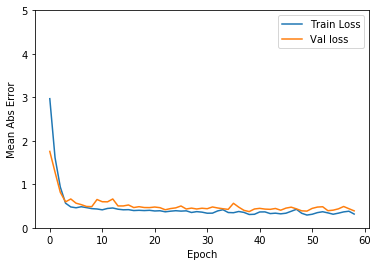

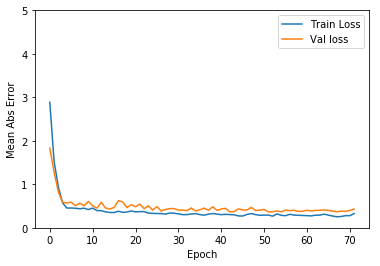

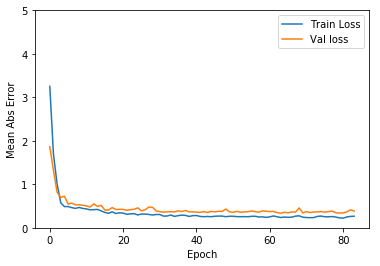

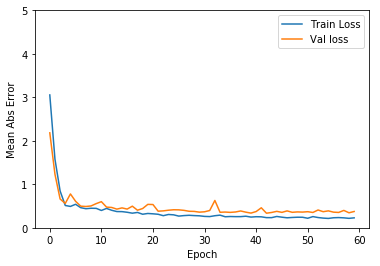

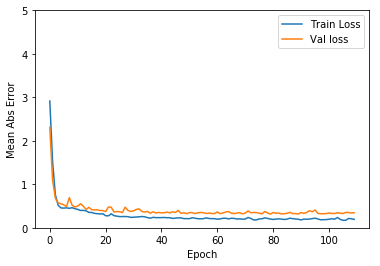

In [18]:
errors = []
for i in np.linspace(2, 4, 5):
    errors.append(cv_dropout_maxnorm(0.2, 0.5, i))

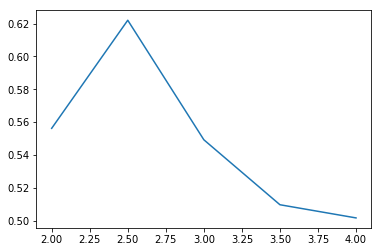

In [19]:
plt.plot(np.linspace(2, 4, 5), errors)

# Try k-fold only estimations

# Weights regularizers

# Try stacking

# Try reduce matrix with more features

Bigger networks enters under the spotlights.

In [5]:
X_pca_train = np.load(DATA_FOLDER + "x_pca_train.npy")[:, :-1]
y_pca_train = np.load(DATA_FOLDER + "y_pca_train.npy")
X_pca_test = np.load(DATA_FOLDER + "x_pca_test.npy")[:, :-1]
y_pca_test = np.load(DATA_FOLDER + "y_pca_test.npy")
X_pca_train.shape, X_pca_test.shape, y_pca_train.shape, y_pca_test.shape

((22536, 4500), (7513, 4500), (22536,), (7513,))

In [8]:
model = tf.keras.Sequential()
for i in range(8):
    model.add(layers.Dense(156, activation='relu', \
                           kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
model.add(layers.Dense(1, activation='relu'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_pca_train, y_pca_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
plot_history(history)

result = model.predict(X_pca_test, batch_size=32)
error = rmse(result, y_pca_test)
print("Error : {}".format(error))

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20282/20282 [==============================] - 9s 432us/step - loss: 29.9325 - mean_absolute_error: 3.6331 - val_loss: 16.6040 - val_mean_absolute_error: 3.2118
Epoch 2/200
20282/20282 [==============================] - 8s 396us/step - loss: 2.1376 - mean_absolute_error: 1.0579 - val_loss: 8.9884 - val_mean_absolute_error: 2.2757
Epoch 3/200
20282/20282 [==============================] - 8s 397us/step - loss: 0.7239 - mean_absolute_error: 0.6215 - val_loss: 8.3732 - val_mean_absolute_error: 2.2331
Epoch 4/200
20282/20282 [==============================] - 8s 394us/step - loss: 0.5530 - mean_absolute_error: 0.5488 - val_loss: 6.6461 - val_mean_absolute_error: 1.9272
Epoch 5/200
20282/20282 [==============================] - 8s 404us/step - loss: 0.5993 - mean_absolute_error: 0.5670 - val_loss: 5.6034 - val_mean_absolute_error: 1.7639
Epoch 6/200
20282/20282 [==============================] - 8s 392us/step - loss: 0.7357 - mean

KeyboardInterrupt: 

## The bigger, the better

In [12]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [13]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20282/20282 [==============================] - 20s 1ms/step - loss: 23.1301 - mean_absolute_error: 2.8865 - val_loss: 2.7541 - val_mean_absolute_error: 1.2903
Epoch 2/200
20282/20282 [==============================] - 15s 734us/step - loss: 1.1507 - mean_absolute_error: 0.7784 - val_loss: 0.6975 - val_mean_absolute_error: 0.5890
Epoch 3/200
20282/20282 [==============================] - 14s 670us/step - loss: 0.4864 - mean_absolute_error: 0.5269 - val_loss: 0.7360 - val_mean_absolute_error: 0.6201
Epoch 4/200
20282/20282 [==============================] - 13s 633us/step - loss: 0.4372 - mean_absolute_error: 0.4988 - val_loss: 0.5303 - val_mean_absolute_error: 0.5168
Epoch 5/200
20282/20282 [==============================] - 13s 649us/step - loss: 0.4716 - mean_absolute_error: 0.5156 - val_loss: 1.2590 - val_mean_absolute_error: 0.8921
Epoch 6/200
20282/20282 [==============================] - 15s 733us/step - loss: 0.4728 - m

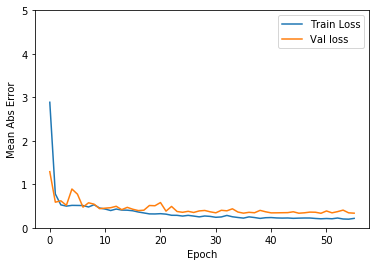

In [25]:
model = tf.keras.Sequential()
model.add(layers.Dropout(0.5))
for i in range(16):
    model.add(layers.Dense(256, activation='relu', \
                           kernel_regularizer=tf.keras.regularizers.l2(5e-6), \
                          kernel_constraint = MaxNorm(4)))
    model.add(layers.Dropout(0.5))
# Last layer represent the electromagnetic shielding, our prediction
model.add(layers.Dense(1, activation='relu'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
plot_history(history)

result = model.predict(X_test_red, batch_size=32)
error = rmse(result, y_test)
print("Error : {}".format(error))